# **Decision tree classification**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
class Node:
    def __init__(
        self,
        split_feature_idx=None,
        treshhold=None,
        left_subtree=None,
        right_subtree=None,
        variance_reduction=None,
        leaf_node_value=None
    ):
        self.split_feature_idx = split_feature_idx
        self.treshhold = treshhold
        self.left_subtree = left_subtree
        self.right_subtree = right_subtree
        self.variance_reduction = variance_reduction

        self.leaf_node_value = leaf_node_value

In [3]:
class Decision_tree_classifier:
    def __init__(self, n_min_samples=2, max_depth=2):
        self.n_min_samples = n_min_samples
        self.max_depth = max_depth

        self.root = None

    def fit(self, X, y):
        data = np.concatenate((X, y), axis=1, dtype=object)
        self.root = self.build_tree(data)

    def build_tree(self, data, current_depth=0):
        X = data[:, :-1]
        y = data[:, -1]

        n_rows, n_columns = X.shape

        if (
            n_rows >= self.n_min_samples
            and current_depth <= self.max_depth
        ):
            best_split_values = self.get_best_split(data, n_columns)

            if best_split_values != {}:
                if best_split_values["node_info_gain"] > 0:
                    left_subtree = self.build_tree(
                        best_split_values["data_left_split"], current_depth + 1
                    )
                    right_subtree = self.build_tree(
                        best_split_values["data_right_split"], current_depth + 1
                    )

                    return Node(
                        best_split_values["split_feature_idx"],
                        best_split_values["treshhold"],
                        left_subtree,
                        right_subtree,
                        best_split_values["node_info_gain"]
                    )

        leaf_node_value = self.calculate_leaf_node(y)

        return Node(leaf_node_value=leaf_node_value)

    def get_best_split(self, data, n_columns):
        max_info_gain = -float("inf")
        best_split_values = {}

        for split_feature_idx in range(n_columns):
            possible_treshholds = np.unique(data[:, split_feature_idx])

            for treshhold in possible_treshholds:
                data_left_split, data_right_split = self.make_split(
                    data, split_feature_idx, treshhold
                )

                if len(data_left_split) > 0 and len(data_right_split) > 0:
                    targets = data[:, -1]
                    left_split_targets = data_left_split[:, -1]
                    right_split_targets = data_right_split[:, -1]

                    info_gain = self.calculate_info_gain(
                        targets,
                        left_split_targets,
                        right_split_targets
                    )

                    if info_gain > max_info_gain:
                        best_split_values["split_feature_idx"] = split_feature_idx
                        best_split_values["treshhold"] = treshhold
                        best_split_values["data_left_split"] = data_left_split
                        best_split_values["data_right_split"] = data_right_split
                        best_split_values["node_info_gain"] = info_gain
                        max_info_gain = info_gain

        return best_split_values

    def make_split(
        self, data, split_feature_idx, treshhold
    ):
        data_left_split = np.array(
            [
                row
                for row in data
                if row[split_feature_idx] <= treshhold
            ]
        )
        data_right_split = np.array(
            [
                row
                for row in data
                if row[split_feature_idx] > treshhold
            ]
        )

        return data_left_split, data_right_split

    def calculate_info_gain(
        self, targets, left_split_targets, right_split_targets
    ):
        n_left_split_targets = len(left_split_targets)
        n_right_split_targets = len(right_split_targets)
        n_targets = len(targets)

        left_split_targets_entropy = self.calculate_entropy(
            left_split_targets
        )
        right_split_targets_entropy = self.calculate_entropy(
            right_split_targets
        )
        targets_entropy = self.calculate_entropy(targets)

        data_impurity = n_targets * targets_entropy
        split_impurity = (
            n_left_split_targets * left_split_targets_entropy
            + n_right_split_targets * right_split_targets_entropy
        )

        info_gain = data_impurity - split_impurity

        return info_gain

    def calculate_entropy(self, data):
        data_labels = np.unique(data)
        data_entropy = 0

        for label in data_labels:
            n_label_objects = len(data[data == label])
            p_label = n_label_objects / len(data)
            data_entropy += -p_label * np.log2(p_label)

        return data_entropy

    def calculate_leaf_node(self, targets):
        targets = list(targets)

        return max(targets, key=targets.count)

    def predict(self, data):
        predictions = np.array(
            [self.make_prediction(sample, self.root) for sample in data]
        )

        return predictions.reshape(-1, 1)

    def make_prediction(self, sample, node):
        if node.leaf_node_value != None:
            return node.leaf_node_value
        else:
            feature_value = sample[node.split_feature_idx]

            if feature_value <= node.treshhold:
                return self.make_prediction(sample, node.left_subtree)
            else:
                return self.make_prediction(sample, node.right_subtree)

In [4]:
df = pd.read_csv(
    "/content/sample_data/data.csv"
)
df

,x1,x2,y
0,7.928921,8.894290,2
1,7.221989,9.110455,2
2,1.216812,2.961291,1
3,6.376725,2.760446,1
4,1.335724,3.847187,1
...,...,...,...
395,0.141050,6.617738,0
396,3.261298,0.209096,1
397,8.862943,1.703210,2
398,7.896676,5.360148,2


In [5]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values.reshape(-1, 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1 / 3, random_state=42
)

X_test_len = len(X_test)
y_test_len = len(y_test)

In [7]:
model = Decision_tree_classifier(n_min_samples=4, max_depth=4)
model.fit(X_train, y_train)

In [8]:
y_pred = model.predict(X_test)
y_pred_len = len(y_pred)

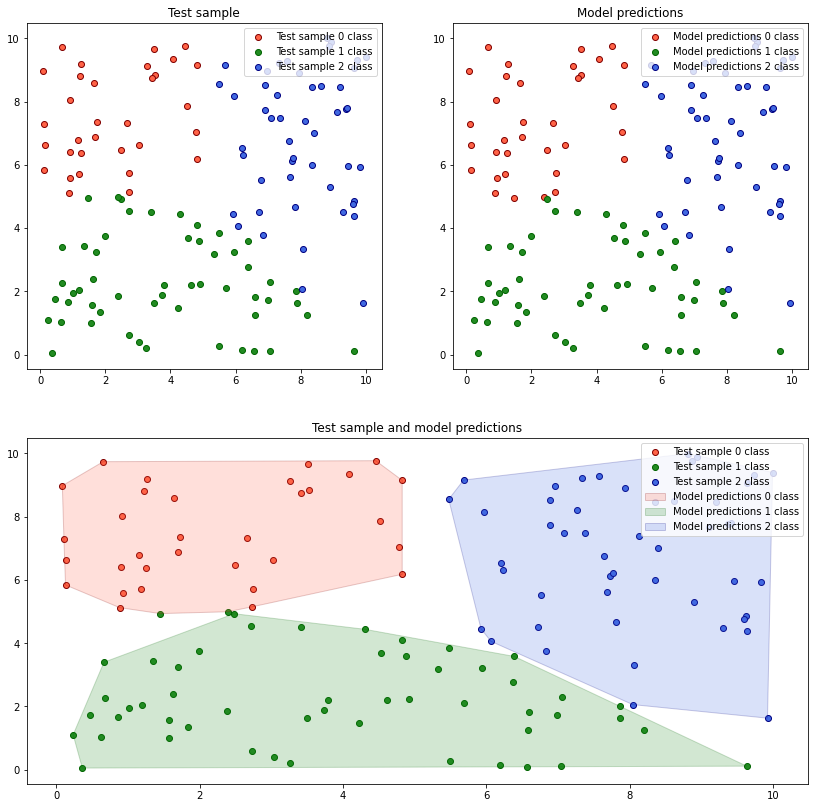

In [9]:
class_0_x1_values = []
class_0_x2_values = []

class_1_x1_values = []
class_1_x2_values = []

class_2_x1_values = []
class_2_x2_values = []

for i in range(y_test_len):
    if y_test[i] == 0:
        class_0_x1_values.append(X_test[i][0])
        class_0_x2_values.append(X_test[i][1])
        continue
    if y_test[i] == 1:
        class_1_x1_values.append(X_test[i][0])
        class_1_x2_values.append(X_test[i][1])
        continue
    if y_test[i] == 2:
        class_2_x1_values.append(X_test[i][0])
        class_2_x2_values.append(X_test[i][1])

pred_class_0_x1_values = []
pred_class_0_x2_values = []

pred_class_1_x1_values = []
pred_class_1_x2_values = []

pred_class_2_x1_values = []
pred_class_2_x2_values = []

for i in range(y_pred_len):
    if y_pred[i] == 0:
        pred_class_0_x1_values.append(X_test[i][0])
        pred_class_0_x2_values.append(X_test[i][1])
        continue
    if y_test[i] == 1:
        pred_class_1_x1_values.append(X_test[i][0])
        pred_class_1_x2_values.append(X_test[i][1])
        continue
    if y_test[i] == 2:
        pred_class_2_x1_values.append(X_test[i][0])
        pred_class_2_x2_values.append(X_test[i][1])

figure = plt.figure()

ax_1 = plt.subplot(221)
ax_2 = plt.subplot(222)
ax_3 = plt.subplot(212)

figure.set_figwidth(14)
figure.set_figheight(14)

ax_1.set_title("Test sample")
ax_1.scatter(
    class_0_x1_values,
    class_0_x2_values,
    color="tomato",
    edgecolors="maroon",
    label="Test sample 0 class",
)
ax_1.scatter(
    class_1_x1_values,
    class_1_x2_values,
    color="forestgreen",
    edgecolors="darkgreen",
    label="Test sample 1 class",
)
ax_1.scatter(
    class_2_x1_values,
    class_2_x2_values,
    color="royalblue",
    edgecolors="navy",
    label="Test sample 2 class",
)

ax_1.legend(loc="upper right")

ax_2.set_title("Model predictions")
ax_2.scatter(
    pred_class_0_x1_values,
    pred_class_0_x2_values,
    color="tomato",
    edgecolors="maroon",
    label="Model predictions 0 class",
)
ax_2.scatter(
    pred_class_1_x1_values,
    pred_class_1_x2_values,
    color="forestgreen",
    edgecolors="darkgreen",
    label="Model predictions 1 class",
)
ax_2.scatter(
    pred_class_2_x1_values,
    pred_class_2_x2_values,
    color="royalblue",
    edgecolors="navy",
    label="Model predictions 2 class",
)

ax_2.legend(loc="upper right")

ax_3.set_title("Test sample and model predictions")
ax_3.scatter(
    class_0_x1_values,
    class_0_x2_values,
    color="tomato",
    edgecolors="maroon",
    label="Test sample 0 class",
)
ax_3.scatter(
    class_1_x1_values,
    class_1_x2_values,
    color="forestgreen",
    edgecolors="darkgreen",
    label="Test sample 1 class",
)
ax_3.scatter(
    class_2_x1_values,
    class_2_x2_values,
    color="royalblue",
    edgecolors="navy",
    label="Test sample 2 class",
)

pred_class_0_x1_x2_values = np.c_[
    pred_class_0_x1_values, pred_class_0_x2_values
]
pred_class_1_x1_x2_values = np.c_[
    pred_class_1_x1_values, pred_class_1_x2_values
]
pred_class_2_x1_x2_values = np.c_[
    pred_class_2_x1_values, pred_class_2_x2_values
]

pred_class_0_hull = ConvexHull(pred_class_0_x1_x2_values)
pred_class_1_hull = ConvexHull(pred_class_1_x1_x2_values)
pred_class_2_hull = ConvexHull(pred_class_2_x1_x2_values)
pred_class_0_polygon = plt.Polygon(
    pred_class_0_x1_x2_values[pred_class_0_hull.vertices, :],
    ec="maroon",
    fc="tomato",
    alpha=0.2,
    label="Model predictions 0 class",
)
pred_class_1_polygon = plt.Polygon(
    pred_class_1_x1_x2_values[pred_class_1_hull.vertices, :],
    ec="darkgreen",
    fc="forestgreen",
    alpha=0.2,
    label="Model predictions 1 class",
)
pred_class_2_polygon = plt.Polygon(
    pred_class_2_x1_x2_values[pred_class_2_hull.vertices, :],
    ec="navy",
    fc="royalblue",
    alpha=0.2,
    label="Model predictions 2 class",
)

ax_3.add_patch(pred_class_0_polygon)
ax_3.add_patch(pred_class_1_polygon)
ax_3.add_patch(pred_class_2_polygon)

ax_3.legend(loc="upper right")

plt.show()

In [10]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9477611940298507

In [11]:
test_df = pd.DataFrame(
    np.concatenate((X_test, y_test), axis=1, dtype=object), columns=["x1", "x2", "y"]
)
test_df

,x1,x2,y
0,0.086012,8.980594,0
1,1.156717,6.793255,0
2,1.988559,3.743057,1
3,7.260547,8.223618,2
4,6.591304,1.813723,1
...,...,...,...
129,1.732003,7.35684,0
130,0.108392,7.286643,0
131,7.058708,2.303671,1
132,6.993561,1.721619,1


In [12]:
test_df = pd.DataFrame(
    np.concatenate((X_test, y_pred), axis=1, dtype=object), columns=["x1", "x2", "y"]
)
test_df

,x1,x2,y
0,0.086012,8.980594,0
1,1.156717,6.793255,0
2,1.988559,3.743057,1
3,7.260547,8.223618,2
4,6.591304,1.813723,1
...,...,...,...
129,1.732003,7.35684,0
130,0.108392,7.286643,0
131,7.058708,2.303671,2
132,6.993561,1.721619,1
